In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import LearningRateScheduler

In [2]:
# Load augmented dataset
BASE_DIR = os.path.abspath("..")
X_train = np.load(os.path.join(BASE_DIR, "X_lesion_train.npy"))
y_train = np.load(os.path.join(BASE_DIR, "y_lesion_train.npy"))
X_test = np.load(os.path.join(BASE_DIR, "X_lesion_test.npy"))
y_test = np.load(os.path.join(BASE_DIR, "y_lesion_test.npy"))

# Print dataset shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (71, 256, 256, 1), y_train shape: (71, 3)
X_test shape: (18, 256, 256, 1), y_test shape: (18, 3)


In [3]:
class_counts = y_train.sum(axis=0)
print(f"Original Class Distribution: {class_counts}")

Original Class Distribution: [41 36 63]


In [4]:
def augment_images(images, labels, target_count, class_label):
    if class_label == 0:  # Class 0 Augmentation (More distortion & rotation)
        datagen = ImageDataGenerator(
            rotation_range=50, width_shift_range=0.35, height_shift_range=0.35,
            zoom_range=0.35, brightness_range=[0.5, 1.5], 
            shear_range=0.3, horizontal_flip=True, fill_mode="nearest"
        )
    elif class_label == 1:  # Class 1 Augmentation (More contrast & perspective)
        datagen = ImageDataGenerator(
            rotation_range=35, width_shift_range=0.2, height_shift_range=0.2,
            zoom_range=0.25, brightness_range=[0.6, 1.4], 
            shear_range=0.2, horizontal_flip=True, fill_mode="nearest"
        )

    augmented_images, augmented_labels = [], []
    
    for i in range(len(images)):
        if labels[i][class_label] == 1:  # Augment only for the specific class
            img = np.expand_dims(images[i], axis=0)
            label = labels[i]

            for _ in range(target_count):
                aug_iter = datagen.flow(img, batch_size=1)
                aug_img = next(aug_iter)[0]
                aug_img = np.clip(aug_img, 0, 1)  # Stability

                augmented_images.append(aug_img)
                augmented_labels.append(label)
    
    return np.array(augmented_images), np.array(augmented_labels)

max_count = class_counts.max()

aug_X, aug_y = [], []
for i in range(len(class_counts)):
    if class_counts[i] < max_count:
        X_aug, y_aug = augment_images(
            X_train[y_train[:, i] == 1], y_train[y_train[:, i] == 1], 
            max_count - class_counts[i], class_label=i
        )
        aug_X.append(X_aug)
        aug_y.append(y_aug)

X_train_balanced = np.concatenate([X_train] + aug_X, axis=0)
y_train_balanced = np.concatenate([y_train] + aug_y, axis=0)

# Shuffle data
idx = np.random.permutation(len(X_train_balanced))
X_train_balanced, y_train_balanced = X_train_balanced[idx], y_train_balanced[idx]

print("New Class Distribution (Summing Labels):", y_train_balanced.sum(axis=0))
print(f"New dataset size: {X_train_balanced.shape}, {y_train_balanced.shape}")

print(np.sum(y_train_balanced, axis=0))

New Class Distribution (Summing Labels): [1726 1646 1790]
New dataset size: (1945, 256, 256, 1), (1945, 3)
[1726 1646 1790]


In [5]:
IMG_SIZE = 128

X_train_resized = np.array([tf.image.resize(img, (IMG_SIZE, IMG_SIZE)).numpy() for img in X_train_balanced])
X_test_resized = np.array([tf.image.resize(img, (IMG_SIZE, IMG_SIZE)).numpy() for img in X_test])

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

def create_tf_dataset(X, y, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(len(X))
    dataset = dataset.batch(batch_size).prefetch(AUTOTUNE) 
    return dataset

# Convert to tf.data pipeline
BATCH_SIZE = 32
train_dataset = create_tf_dataset(X_train_resized, y_train_balanced, batch_size=BATCH_SIZE)
test_dataset = create_tf_dataset(X_test_resized, y_test, batch_size=BATCH_SIZE, shuffle=False)

In [7]:
BATCH_SIZE = 64
EPOCHS = 100
INITIAL_LR = 5e-4

def lr_schedule(epoch, lr):
    """Gradually reduce the learning rate with a controlled decay."""
    initial_lr = 5e-4  
    decay_factor = 0.9  # Reduce by 10% every 5 epochs
    decay_epochs = 5  
    
    new_lr = initial_lr * (decay_factor ** (epoch // decay_epochs))
    
    print(f"Epoch {epoch+1}: Adjusting learning rate to {new_lr:.6f}")
    return new_lr
#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate=2e-4, decay_steps=1000, decay_rate=0.9, staircase=True
#)

lr_callback = LearningRateScheduler(lr_schedule, verbose=1)

In [8]:
model = Sequential([
    Conv2D(32, (3,3), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 1), kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    #Dropout(0.3),

    Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)), 
    #Dropout(0.3),

    Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    #Dropout(0.3),

    Flatten(),
    Dense(256, kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.4),  
    Dense(3, activation='sigmoid')  
])

initial_learning_rate = 5e-4
optimizer = tf.keras.optimizers.AdamW(learning_rate=initial_learning_rate, weight_decay=1e-4)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['AUC'])

model.summary()

/Users/priyanshuraj/Development/College_project/Retinal_Disease_Detection/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,484,227 (32.36 MB)

 Trainable params: 8,483,267 (32.36 MB)

 Non-trainable params: 960 (3.75 KB)

In [9]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)


In [10]:
class_weights = {0: 1.0, 1: 1.2, 2: 1.0}  # Increase weight for Class 1

history = model.fit(
    train_dataset, 
    validation_data=test_dataset, 
    epochs=35, 
    class_weight=class_weights,  # Apply class weights
    callbacks=[early_stopping, lr_callback]  
)

Epoch 1: Adjusting learning rate to 0.000500

Epoch 1: LearningRateScheduler setting learning rate to 0.0005.
Epoch 1/35
61/61 ━━━━━━━━━━━━━━━━━━━━ 19s 299ms/step - AUC: 0.5293 - loss: 0.9873 - val_AUC: 0.5015 - val_loss: 0.9675 - learning_rate: 5.0000e-04
Epoch 2: Adjusting learning rate to 0.000500

Epoch 2: LearningRateScheduler setting learning rate to 0.0005.
Epoch 2/35
61/61 ━━━━━━━━━━━━━━━━━━━━ 18s 300ms/step - AUC: 0.6054 - loss: 0.6555 - val_AUC: 0.6662 - val_loss: 0.9987 - learning_rate: 5.0000e-04
Epoch 3: Adjusting learning rate to 0.000500

Epoch 3: LearningRateScheduler setting learning rate to 0.0005.
Epoch 3/35
61/61 ━━━━━━━━━━━━━━━━━━━━ 19s 308ms/step - AUC: 0.6440 - loss: 0.6222 - val_AUC: 0.6820 - val_loss: 1.0033 - learning_rate: 5.0000e-04
Epoch 4: Adjusting learning rate to 0.000500

Epoch 4: LearningRateScheduler setting learning rate to 0.0005.
Epoch 4/35
61/61 ━━━━━━━━━━━━━━━━━━━━ 19s 311ms/step - AUC: 0.6750 - loss: 0.5809 - val_AUC: 0.6150 - val_loss: 0.8632 

In [11]:
test_loss, test_acc = model.evaluate(test_dataset, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - AUC: 0.8504 - loss: 0.5248
Test Accuracy: 0.8504


In [12]:
from sklearn.metrics import classification_report
import numpy as np

# Extract true labels
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Get model predictions (probabilities)
y_pred = model.predict(test_dataset)

# Define per-class decision thresholds
thresholds = np.array([0.50, 0.45, 0.50])  # Adjust these values as needed

# Apply custom thresholds
y_pred = (y_pred > thresholds).astype(int)

# Generate classification report
print(classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1', 'Class 2']))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
              precision    recall  f1-score   support

     Class 0       0.90      0.90      0.90        10
     Class 1       0.70      0.78      0.74         9
     Class 2       0.89      1.00      0.94        16

   micro avg       0.84      0.91      0.88        35
   macro avg       0.83      0.89      0.86        35
weighted avg       0.84      0.91      0.88        35
 samples avg       0.82      0.83      0.80        35



2025-02-10 22:36:05.625411: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/Users/priyanshuraj/Development/College_project/Retinal_Disease_Detection/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


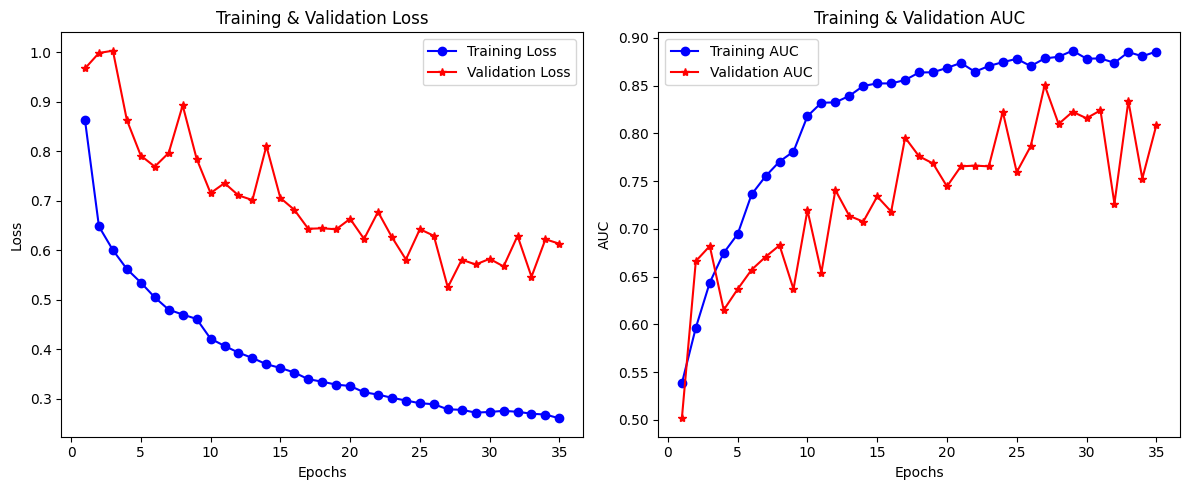

In [13]:
import matplotlib.pyplot as plt

# Extract values from history
epochs = range(1, len(history.history['loss']) + 1)

# 📌 Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'], 'bo-', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'r*-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# 📌 Plot AUC (using the correct key)
auc_key = 'auc' if 'auc' in history.history else 'AUC'
val_auc_key = 'val_auc' if 'val_auc' in history.history else 'val_AUC'
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history[auc_key], 'bo-', label='Training AUC')
plt.plot(epochs, history.history[val_auc_key], 'r*-', label='Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Training & Validation AUC')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
model.save("../Retinal_Disease_Detection/cnn1_lesion_detector.h5")

In [16]:
from tensorflow.keras.models import load_model

model = load_model('../Retinal_Disease_Detection/cnn1_lesion_detector.h5')
print(model.summary())  # Confirm architecture

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,484,229 (32.36 MB)

 Trainable params: 8,483,267 (32.36 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 2 (12.00 B)

None


In [18]:
print(X_test.shape)  # Ensure it matches the expected CNN input

(18, 256, 256, 1)


In [19]:
import numpy as np

lesion_outputs = model.predict(X_test_resized)  # Use actual test data
np.save('Retinal_Disease_Detection/lesion_outputs.npy', lesion_outputs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
